In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tests_hw4 import test_prediction, test_generation

In [2]:
device = torch.device('cuda')

In [3]:
# load all that we need

dataset = np.load('../dataset/wiki.train.npy', allow_pickle=True)
devset = np.load('../dataset/wiki.valid.npy', allow_pickle=True)
fixtures_pred = np.load('../fixtures/prediction.npz')  # dev
fixtures_gen = np.load('../fixtures/generation.npy')  # dev
fixtures_pred_test = np.load('../fixtures/prediction_test.npz')  # test
fixtures_gen_test = np.load('../fixtures/generation_test.npy')  # test
vocab = np.load('../dataset/vocab.npy')

In [4]:
print(len(dataset))
print(dataset[0])

579
[ 1420 13859  3714 ...   813    79  1417]


In [5]:
dataset_len = np.arange(dataset.shape[0])
np.random.shuffle(dataset_len)
dataset = dataset[dataset_len]
dataset_all = np.concatenate(dataset)
dataset_all.shape

(2075677,)

In [6]:
seq_len = 3

In [7]:
# data loader

class DataLoaderForLanguageModeling(DataLoader):
    """
        TODO: Define data loader logic here
    """
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset # TODO
        self.batch_size = batch_size # TODO
        self.shuffle = shuffle # TODO 
        
        # raise NotImplemented


    def __iter__(self):
        """
            You may implement some of the techniques in https://arxiv.org/pdf/1708.02182.pdf
            example: Variable length backpropagation sequences (Section 4.1)
        """
        # 1. Randomly shuffle all the articles from the WikiText-2 dataset.
        # 2. Concatenate all text in one long string.
        # 3. Group the sequences into batches.
        # 4. Run a loop that returns a tuple of (input, label) on every iteration with yield.
        
        dataset_len = np.arange(self.dataset.shape[0])
        if self.shuffle:
            np.random.shuffle(dataset_len)
        dataset = self.dataset[dataset_len]
        dataset_all = np.concatenate(dataset)
        # print(dataset.shape)
        # print(dataset_all.shape)
        # print(dataset_all[0])
        # dataset_all = dataset_all.reshape(self.batch_size, -1)
        dataloader = DataLoader((dataset_all), batch_size = self.batch_size*seq_len + 1, drop_last=True)
        
        for data in dataloader:
            inputs, targets = [], []
            for b in range(self.batch_size):
                inputs.append(data[b*seq_len:(b+1)*seq_len])
                targets.append(data[b*seq_len+1:(b+1)*seq_len+1])
            # yield (data[:seq_len], data[1:seq_len+1])
            yield (torch.stack(inputs), torch.stack(targets))

        
        

In [8]:
loader = DataLoaderForLanguageModeling(
    dataset=dataset, 
    batch_size=64, 
    shuffle=True
)

for batch_num, (inputs, targets) in enumerate(loader):
    print(batch_num)
    print(inputs.shape)
    print(targets.shape)
    if batch_num == 5:
        break

0
torch.Size([64, 3])
torch.Size([64, 3])
1
torch.Size([64, 3])
torch.Size([64, 3])
2
torch.Size([64, 3])
torch.Size([64, 3])
3
torch.Size([64, 3])
torch.Size([64, 3])
4
torch.Size([64, 3])
torch.Size([64, 3])
5
torch.Size([64, 3])
torch.Size([64, 3])


In [9]:
# model

class Model(nn.Module):
    """
        TODO: Define your model here
    """
    def __init__(self, vocab_size:int, embedding_dim:int, hidden_size:int):
        super(Model, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.rnn = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_size, num_layers = 2, bidirectional = True, batch_first=True,  dropout=0.3)
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(nn.Linear(self.hidden_size*2, 1024),
                                nn.Dropout(0.3), 
                                nn.ReLU(),
                                nn.Linear(1024, self.vocab_size))
        
        # raise NotImplemented


    def forward(self, x):
        # Feel free to add extra arguments to forward (like an argument to pass in the hiddens)
        x = self.embedding(x)
        out, (hn, cn) = self.rnn(x)
#         print(x.shape)
#         out = self.flatten(out[:, -1, :])
#         print(x.shape)
        out= self.fc(out)
#         print(out.shape)
        
        return out
        # raise NotImplemented
    


In [24]:
# model trainer

class Trainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        # TODO: Define your optimizer and criterion here
        # feel free to define a learning rate scheduler as well if you want
        self.optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-3)
#         self.criterion = nn.NLLLoss()
        self.criterion = nn.CrossEntropyLoss()

    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        num_batches = 0
        for batch_num, (inputs, targets) in tqdm(enumerate(self.loader)):
            epoch_loss += self.train_batch(inputs, targets)
#             if batch_num == 500:
#                 break
        epoch_loss = epoch_loss / (batch_num + 1)
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    def train_batch(self, inputs, targets):
        """ 
            TODO: Define code for training a single batch of inputs
            
            :return 
                    (float) loss value
        """
        # raise NotImplemented
        inputs = inputs.type(torch.int64).to(device)
        targets = targets.type(torch.int64).to(device)
        output = self.model(inputs)
        loss = self.criterion(output.permute(0,2,1), targets)
        loss.backward()
        self.optimizer.step()
        
        return loss.item()

    
    def test(self):
        # don't change these
        self.model.eval() # set to eval mode
        predictions = TestLanguageModel.predict(fixtures_pred['inp'], self.model) # get predictions
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generate(fixtures_gen, 10, self.model) # generated predictions for 10 words
        generated_logits_test = TestLanguageModel.generate(fixtures_gen_test, 10, self.model)
        nll = test_prediction(predictions, fixtures_pred['out'])
        generated = test_generation(fixtures_gen, generated_logits, vocab)
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.predict(fixtures_pred_test['inp'], self.model) # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, nll))
        self.epochs += 1

        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [25]:
class TestLanguageModel:
    def predict(inp, model):
        """
            TODO: write prediction code here
            
            :param inp:
            :return: a np.ndarray of logits
        """
        inp = torch.LongTensor(inp).to(device)
        output = model(inp)
        
        return output[:, -1].detach().cpu().numpy()
        # raise NotImplemented

        
    def generate(inp, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
        """        
        generated = []
        
        for i in range(forward):
            inp = torch.LongTensor(inp).to(device)
            output = model(inp).detach().cpu().numpy()
            inp = inp.detach().cpu().numpy()
            next_word = np.argmax(output[:, -1], axis=1)
            generated.append(next_word)
            inp = np.append(inp[:, 1:], next_word.reshape(-1, 1), axis=1)

        return np.transpose(np.array(generated))
        # raise NotImplemented
    
        

In [26]:
# TODO: define other hyperparameters here

NUM_EPOCHS = 10
BATCH_SIZE = 64
EMB_DIM = 1024
HIDDEN_SIZE = 256

In [27]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1672638691


In [28]:
model = Model(len(vocab), embedding_dim=EMB_DIM, hidden_size=HIDDEN_SIZE).to(device)

loader = DataLoaderForLanguageModeling(
    dataset=dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
trainer = Trainer(
    model=model, 
    loader=loader, 
    max_epochs=NUM_EPOCHS, 
    run_id=run_id
)

In [29]:
best_nll = 1e30 
for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))
        trainer.save()
    

10754it [03:24, 52.65it/s]


[TRAIN]  Epoch [1/10]   Loss: 8.4053
[VAL]  Epoch [1/10]   Loss: 6.9872
Saving model, predictions and generated output for epoch 0 with NLL: 6.9871583


10754it [03:41, 48.59it/s]


[TRAIN]  Epoch [2/10]   Loss: 11.2998
[VAL]  Epoch [2/10]   Loss: 6.9761
Saving model, predictions and generated output for epoch 1 with NLL: 6.976074


10754it [04:09, 43.10it/s]


[TRAIN]  Epoch [3/10]   Loss: 15.9018


1it [00:00,  7.20it/s]

[VAL]  Epoch [3/10]   Loss: 7.2787


10754it [04:04, 43.95it/s]


[TRAIN]  Epoch [4/10]   Loss: 24.1421
[VAL]  Epoch [4/10]   Loss: 6.9315
Saving model, predictions and generated output for epoch 3 with NLL: 6.9314775


10754it [04:01, 44.56it/s]


[TRAIN]  Epoch [5/10]   Loss: 34.0616
[VAL]  Epoch [5/10]   Loss: 6.9075
Saving model, predictions and generated output for epoch 4 with NLL: 6.9075036


10754it [04:01, 44.61it/s]


[TRAIN]  Epoch [6/10]   Loss: 42.3788


5it [00:00, 49.02it/s]

[VAL]  Epoch [6/10]   Loss: 7.1695


10754it [04:00, 44.71it/s]


[TRAIN]  Epoch [7/10]   Loss: 57.2116


6it [00:00, 51.21it/s]

[VAL]  Epoch [7/10]   Loss: 6.9117


10754it [04:01, 44.54it/s]


[TRAIN]  Epoch [8/10]   Loss: 79.6096


3it [00:00, 28.76it/s]

[VAL]  Epoch [8/10]   Loss: 6.9187


10754it [04:00, 44.74it/s]


[TRAIN]  Epoch [9/10]   Loss: 81.9518


5it [00:00, 49.06it/s]

[VAL]  Epoch [9/10]   Loss: 7.0779


10754it [03:59, 44.98it/s]


[TRAIN]  Epoch [10/10]   Loss: 124.6405
[VAL]  Epoch [10/10]   Loss: 7.0228


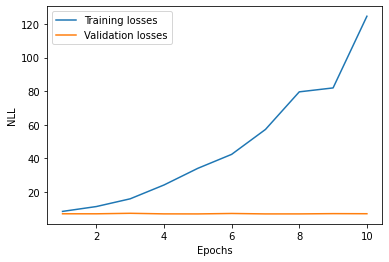

In [30]:
# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [17]:
# see generated output
print (trainer.generated[-1]) # get last generated output

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | the the the the the the the the the the
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | the the the the the the the the the the
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | the the the the the the the the the the
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | the the the the the the the the the the
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | the the the the the the the the the the
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | the the the the the the the the the the
Input | Output #6: <unk> , $ 96 million USD ) . Damage was